In [1]:
!pip install transformers

     |████████████████████████████████| 1.3MB 3.4MB/s 
     |████████████████████████████████| 2.9MB 15.5MB/s 
     |████████████████████████████████| 1.1MB 31.8MB/s 
     |████████████████████████████████| 890kB 45.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=867561c6f731be3cd05e115755e12ab60591e97e47bde6631e6e96f66edffa28
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#! cp '/content/drive/My Drive/tweet-sentiment-extraction/preprocessed_train.csv' .
#! cp '/content/drive/My Drive/tweet-sentiment-extraction/preprocessed_test.csv' .
! cp '/content/drive/My Drive/tweet-sentiment-extraction/train.csv' .
! cp '/content/drive/My Drive/tweet-sentiment-extraction/test.csv' .

In [5]:
#train_df = pd.read_csv('preprocessed_train.csv')
#test_df = pd.read_csv('preprocessed_test.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [6]:
train_df.shape,test_df.shape

((27481, 4), (3534, 3))

In [7]:
train_df.sample(10)

,textID,text,selected_text,sentiment
195,ef12a3d183,i talk to you,i talk to you,neutral
7119,b0a274d394,very long by the sounds of things... But dead...,very long by the sounds of things... But deadl...,neutral
23843,5e7dfb5b07,OMG THAT`S AWESOME. this is the first time ev...,AWESOME.,positive
18272,7eb95958a1,"That be it, my Nathan sense was tingling.","That be it, my Nathan sense was tingling.",neutral
2118,86a04de3a2,hahaha we just won`t tell him will we?,hahaha we just won`t tell him will we?,neutral
757,8a8c28f5ba,Thanks Amy! That video is so awesome! Did y...,e`s amazi,positive
14261,3e9bcfb23e,I managed to find few places where you can co...,"fun,",positive
13903,3338b13120,Saw the new Star Trek movie yesterday `twas v...,good.,positive
24067,f231b83aca,if i had a car,if i had a car,neutral
22724,c78d8bc843,I really want a Shish kebab... Going to have ...,I really want a Shish kebab... Going to have t...,neutral


In [8]:
test_df.sample(5)

,textID,text,sentiment
349,1fee7a1358,Headed home ... Charlie`s at the vet,neutral
57,d33ed264b3,almost got a kitty yesterday...but it didn`t w...,neutral
1487,703a5708f6,Please let me know if it is allright DE i nee...,positive
1746,095410237d,"Just saw Star Trek! It was AMAZING! Seriously,...",positive
2576,6d6e5c1d96,i love the game! that`s my show... suuuppper ...,positive


In [9]:
train_df.isnull().sum(),test_df.isnull().sum()

(textID           0
 text             1
 selected_text    1
 sentiment        0
 dtype: int64, textID       0
 text         0
 sentiment    0
 dtype: int64)

In [10]:
train_df[train_df.text.isna()]


,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [11]:
train_df.dropna(axis=0,inplace=True)
train_df.shape,test_df.shape

((27480, 4), (3534, 3))

In [12]:
train_df.duplicated().sum(),test_df.duplicated().sum()

(0, 0)

In [13]:
train_df.sample(7)

,textID,text,selected_text,sentiment
22008,6c0e2fd56e,If you haven`t changed your mind by mid-June ...,If you haven`t changed your mind by mid-June t...,neutral
20226,5eb5c6cc2c,won`t anyone give poor ernie reyes jr a break?,poor,negative
6265,4a139ed15e,Grrrr....I got the wrong size coat for the sheep,wrong size,negative
14068,1cd52410f7,. Really I look like a boy!!! I need someone t...,. Really I look like a boy!!! I need someone t...,neutral
9746,a52da95df5,Its two o clock in the morning!,Its two o clock in the morning!,neutral
10475,c0d81f0f35,I wish we could make a quick trip to LA in Ju...,I miss,negative
17115,b0a446fd94,ahh i wish you guys would come to a hot topic...,ahh i wish you guys would come to a hot topic ...,neutral


In [14]:
train_df['text'] = train_df['text'].progress_apply(lambda x : str(x).lower())
train_df['selected_text'] = train_df['selected_text'].progress_apply(lambda x : str(x).lower())

In [15]:
train_df.sample(10)

,textID,text,selected_text,sentiment
6265,4a139ed15e,grrrr....i got the wrong size coat for the sheep,wrong size,negative
2951,a7b2b3ec1d,chillaxing in hyde park,chillaxing,positive
8192,024c74397e,"plan for this evening: dinner, shopping for dr...","plan for this evening: dinner, shopping for dr...",neutral
22602,c63d292edc,your understanding would require taking parag...,your understanding would require taking paragr...,neutral
18156,38ff378dd7,i really want to go see up! haha. tooo cute! (:,tooo cute!,positive
19616,162d33e031,glad you could make it,glad you could make it,positive
10161,f90f887354,good monday morning to everyone- hope everyone...,good monday morning to,positive
23019,90b3033569,http://twitpic.com/4jfkw - afc! oh yess,oh yess,positive
19763,835bc372d0,it was a lovely attempt at poetry!,lovely,positive
20874,c7c86f06b5,"trying to upload a custom background on here, ...",but it`s not working,negative


In [16]:
train_df[train_df.text=='']

,textID,text,selected_text,sentiment


In [17]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base',add_prefix_space=True)
tokenizer.encode(' hello world'),tokenizer.encode('hello world')

([0, 20760, 232, 2], [0, 20760, 232, 2])

In [18]:
tokenizer.encode('positive'),tokenizer.encode('negative'),tokenizer.encode('neutral')

([0, 1313, 2], [0, 2430, 2], [0, 7974, 2])

In [19]:
tokenizer.decode([0,1313,2])

'<s> positive</s>'

In [20]:
train_df['sentiment'].value_counts()/274.8

neutral     40.454876
positive    31.229985
negative    28.315138
Name: sentiment, dtype: float64

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_val , y_train , y_val = train_test_split(train_df[['text','sentiment']],train_df['selected_text'],test_size=0.2, random_state=42)
x_train.shape, x_val.shape , y_train.shape , y_val.shape

((21984, 2), (5496, 2), (21984,), (5496,))

In [22]:
x_train['sentiment'].value_counts()/ (x_train.shape[0]/100), x_val['sentiment'].value_counts()/ (x_val.shape[0]/100)

(neutral     40.397562
 positive    31.359170
 negative    28.243268
 Name: sentiment, dtype: float64, neutral     40.684134
 positive    30.713246
 negative    28.602620
 Name: sentiment, dtype: float64)

**input_ids** - Indices of input sequence tokens in the vocabulary.

The input ids are often the only required parameters to be passed to the model as input. They are token indices, numerical representations of tokens building the sequences that will be used as input by the model.

**attention_mask** – Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]:

1 for tokens that are not masked,

0 for tokens that are maked.

The attention mask is an optional argument used when batching sequences together. This argument indicates to the model which tokens should be attended to, and which should not.


In [23]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))
jaccard('i am a vad guy','i am    a    vad    guy')

1.0

In [32]:
MAX_LEN=128
count = x_train.shape[0]
input_ids = np.zeros((count,MAX_LEN),dtype='int32')
attention_mask = np.zeros((count,MAX_LEN),dtype='int32')
start_tokens = np.zeros((count,MAX_LEN),dtype='int32')
end_tokens = np.zeros((count,MAX_LEN),dtype='int32')
toks_all = []

In [33]:
count=0
for i,each in tqdm(enumerate(x_train.values)):
  val = tokenizer.encode_plus(each[0],each[1],add_special_tokens=True,max_length=128,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
  input_ids[i] = val['input_ids']
  attention_mask[i] = val['attention_mask']
  text1 = " "+" ".join(each[0].split())
  text2 = " ".join(y_train.values[i].split())
  #finding the start index 
  idx = text1.find(text2)
  chars = np.zeros((len(text1)))
  chars[idx:idx+len(text2)]=1
  if text1[idx-1]==' ':
    chars[idx-1] = 1


  enc = tokenizer.encode(text1) 
  offsets = []; idx=0
  for t in enc:
    w=tokenizer.decode([t])
    offsets.append((idx,idx+len(w)))
    idx += len(w)

  toks = []
  for c,(a,b) in enumerate(offsets):
    sm = np.sum(chars[a:b])
    if sm>0:
      toks.append(c)
  toks_all.append(toks)    
  if len(toks)>0:
    count+=1
    start_tokens[i,(toks[0])+1] = 1
    end_tokens[i,(toks[-1])+1] = 1
  

21984it [00:18, 1199.19it/s]


In [34]:
input_ids.shape,attention_mask.shape,start_tokens.shape,end_tokens.shape

((21984, 128), (21984, 128), (21984, 128), (21984, 128))

In [37]:
#Visualize the results
import random

for _ in range(35,50):
  i = random.randint(0,x_train.shape[0])
  print(x_train.iloc[i]['text'])
  print(y_train.values[i])
  print([tokenizer.decode([x]) for x in tokenizer.encode(x_train.iloc[i]['text'])])
  print('Input ids',input_ids[i])
  print('attention mask',attention_mask[i])
  print('Start tokens',start_tokens[i])
  print('end   Tokens',end_tokens[i])
  print('Toks',toks_all[i])
  a = np.argmax(start_tokens[i])
  b=np.argmax(end_tokens[i])
  print(a,b)
  text1 = " "+" ".join(x_train.iloc[i]['text'].split())
  enc = tokenizer.encode(text1)
  st = tokenizer.decode(enc[a:b+1])
  print(st)
  print('*'*50)

getting ready to go to ikea. all alone cuz no one will go with me
all alone cuz no one will go with me
['<s>', ' getting', ' ready', ' to', ' go', ' to', ' ', 'ike', 'a', '.', ' all', ' alone', ' c', 'uz', ' no', ' one', ' will', ' go', ' with', ' me', '</s>']
Input ids [   0  562 1227    7  213    7 1437 4348  102    4   70 1937  740 4987
  117   65   40  213   19  162    2    2 2430    2    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1]
attention mask [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 

In [38]:
MAX_LEN=128
count = y_val.shape[0]
input_ids_val = np.zeros((count,MAX_LEN),dtype='int32')
attention_mask_val = np.zeros((count,MAX_LEN),dtype='int32')
start_tokens_val = np.zeros((count,MAX_LEN),dtype='int32')
end_tokens_val = np.zeros((count,MAX_LEN),dtype='int32')

In [39]:
count=0
for i,each in tqdm(enumerate(x_val.values)):
  val = tokenizer.encode_plus(each[0],each[1],add_special_tokens=True,max_length=128,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
  input_ids_val[i] = val['input_ids']
  attention_mask_val[i] = val['attention_mask']
  text1 = " "+" ".join(each[0].split())
  text2 = " ".join(y_val.values[i].split())
  #finding the start index 
  idx = text1.find(text2)
  chars = np.zeros((len(text1)))
  chars[idx:idx+len(text2)]=1
  if text1[idx-1]==' ':
    chars[idx-1] = 1


  enc = tokenizer.encode(text1) 
  offsets = []; idx=0
  for t in enc:
    w=tokenizer.decode([t])
    offsets.append((idx,idx+len(w)))
    idx += len(w)

  toks = []
  for c,(a,b) in enumerate(offsets):
    sm = np.sum(chars[a:b])
    if sm>0:
      toks.append(c)
  toks_all.append(toks)    
  if len(toks)>0:
    count+=1
    start_tokens_val[i,(toks[0])+1] = 1
    end_tokens_val[i,(toks[-1])+1] = 1
  

5496it [00:04, 1140.15it/s]


In [40]:
input_ids_val.shape,attention_mask_val.shape,start_tokens_val.shape,end_tokens_val.shape

((5496, 128), (5496, 128), (5496, 128), (5496, 128))

In [44]:
#Visualize the results
import random

for _ in range(35,50):
  i = random.randint(0,x_val.shape[0])
  print(x_val.iloc[i]['text'])
  print(y_val.values[i])
  print([tokenizer.decode([x]) for x in tokenizer.encode(x_val.iloc[i]['text'])])
  print('Input ids',input_ids[i])
  print('attention mask',attention_mask[i])
  print('Start tokens',start_tokens[i])
  print('end   Tokens',end_tokens[i])
  #print('Toks',toks_all[i])
  a = np.argmax(start_tokens_val[i])
  b=np.argmax(end_tokens_val[i])
  print(a,b)
  text1 = " "+" ".join(x_val.iloc[i]['text'].split())
  enc = tokenizer.encode(text1)
  st = tokenizer.decode(enc[a:b+1])
  print(st)
  print('*'*50)

just uploaded my new blog... a painful story about an 80s year old man who cried because he wanted to die... very sad
painful
['<s>', ' just', ' uploaded', ' my', ' new', ' blog', '...', ' a', ' painful', ' story', ' about', ' an', ' 80', 's', ' year', ' old', ' man', ' who', ' cried', ' because', ' he', ' wanted', ' to', ' die', '...', ' very', ' sad', '</s>']
Input ids [    0  1437  2446    13   511   328  1437  1256  6336 13561    47    33
    89 29784     2     2  7974     2     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1

In [45]:
from transformers import TFRobertaForQuestionAnswering
roberta = TFRobertaForQuestionAnswering.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaForQuestionAnswering: ['lm_head']
- This IS expected if you are initializing TFRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Softmax,Dense,Activation,Dropout

In [47]:
input1 = Input(shape=(MAX_LEN,),name='input_id',dtype=tf.int32)
input2 = Input(shape=(MAX_LEN,),name='attention_mask',dtype=tf.int32)
start_scores,end_scores = roberta(input1,attention_mask = input2)
dense1 = Dense(units=MAX_LEN,activation='relu',name='dense1',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(start_scores)
softmax1 = Activation('softmax')(dense1)
dense2 = Dense(units=MAX_LEN,activation='relu',name='dense2',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(end_scores)
softmax2 = Activation('softmax')(dense2)

In [48]:
model = Model(inputs=[input1,input2],outputs=[softmax1,softmax2])

In [49]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_id (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_for_question_answeri ((None, 128), (None, 124647170   input_id[0][0]                   
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense1 (Dense)                  (None, 128)          16512       tf_roberta_for_questio

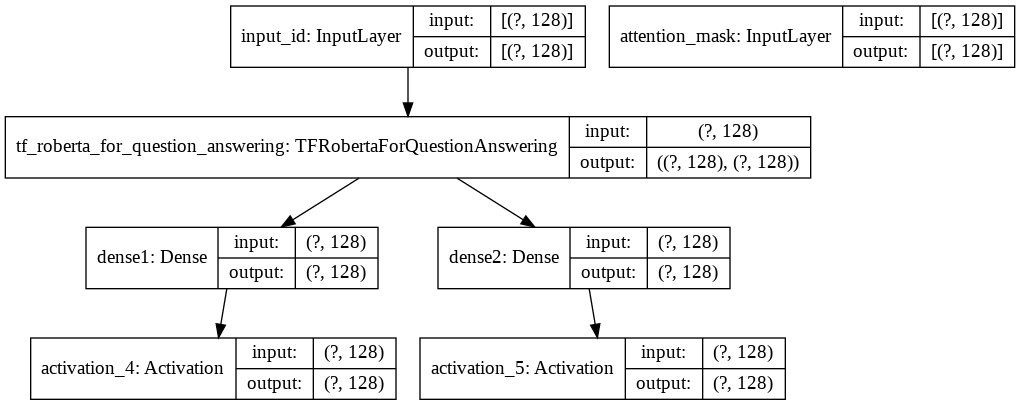

In [50]:
import tensorflow as tf
tf.keras.utils.plot_model(model, 'Model.png',show_shapes=True)

In [51]:
! rm -r '/content/checkpt'
! rm -r '/content/tensorboard_logs1'

rm: cannot remove '/content/checkpt': No such file or directory
rm: cannot remove '/content/tensorboard_logs1': No such file or directory


In [52]:
input_data = (input_ids,attention_mask)
output_data = (start_tokens,end_tokens)

val = (input_ids_val,attention_mask_val)
output_val = (start_tokens_val,end_tokens_val)
val_data = (val,output_val)

In [53]:
%load_ext tensorboard
import datetime
import os
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2,verbose=3,min_lr = 1e-9)
log_dir= os.path.join("tensorboard_logs1" , datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
! mkdir  'checkpt'
file_path = os.path.join('checkpt/model.hdf5')
checkpt_save = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,save_weights_only=True,monitor='val_loss',save_best_only=True,verbose=1)
callbacks=[tensorboard_callback,checkpt_save]

In [54]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
model.compile(optimizer=opt,loss='categorical_crossentropy')

In [55]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_data, output_data)).shuffle(buffer_size=1024).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data).batch(32)

In [56]:
#model.fit(input_data,output_data,epochs=10,batch_size=128,validation_data=val_data,callbacks=callbacks)
model.fit(train_dataset,epochs=15,validation_data=val_dataset,callbacks=callbacks)

Epoch 1/15
  1/687 [..............................] - ETA: 0s - loss: 9.7308 - activation_4_loss: 4.8630 - activation_5_loss: 4.8653WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
687/687 [==============================] - ETA: 0s - loss: 6.8255 - activation_4_loss: 2.6957 - activation_5_loss: 4.1273
Epoch 00001: val_loss improved from inf to 5.30044, saving model to checkpt/model.hdf5
687/687 [==============================] - 817s 1s/step - loss: 6.8255 - activation_4_loss: 2.6957 - activation_5_loss: 4.1273 - val_loss: 5.3004 - val_activation_4_loss: 1.9501 - val_activation_5_loss: 3.3477
Epoch 2/15
687/687 [==============================] - ETA: 0s - loss: 4.8416 - activation_4_loss: 1.8373 - activation_5_loss: 3.0018
Epoch 00002: val_loss improved from 5.

In [57]:
! cp '/content/checkpt' '/content/drive/My Drive/tweet-sentiment-extraction'

cp: -r not specified; omitting directory '/content/checkpt'


In [ ]:
stop

In [ ]:
#tf.keras.backend.clear_session()
#%tensorboard --logdir $log_dir --port 0

In [ ]:
model.load_weights('checkpt/model.hdf5')
start_pred_train , end_pred_train = model.predict((input_data))
start_pred_train.shape,end_pred_train.shape

((21974, 92), (21974, 92))

In [ ]:
strt =[]
end=[]
pred_values = []
for i in tqdm(range(start_pred_train.shape[0])):
  s = np.argmax(start_pred_train[i,])
  e = np.argmax(end_pred_train[i,])
  text1 = " "+" ".join(x_train['text'][i].split())
  enc = tokenizer.encode(text1)
  st = tokenizer.decode(enc.ids[s-1:e])
  pred_values.append(st)
  #s = tf.math.argmax(start_pred_train[i],axis=0).numpy()
  #e = tf.math.argmax(end_pred_train[i],axis=0).numpy()
  #strt.append(s)
  #end.append(e)

len(strt),len(end)  

100%|██████████| 21974/21974 [00:10<00:00, 2149.72it/s]


(21974, 21974)

In [ ]:
'''
for i in tqdm(range(len(strt))):
  index1 = strt[i]
  index2 = end[i] +1
  pred = input_ids[i][index1:index2]
  mystring = tokenizer.decode(pred)
  pred_values.append(mystring)

actual_values = (y_train.values)
len(actual_values),len(pred_values) '''

100%|██████████| 21974/21974 [00:00<00:00, 61279.41it/s]


(21974, 21974)

In [ ]:
x_train

,text,sentiment
22726,"its a calander calendar! collander! bahaha, th...",positive
1232,"lol! i thought we was suppose to guess curse, ...",neutral
532,today was a lovely day! i had fun with and thi...,positive
17260,i`ve got a dentist`s appointment soon! the dri...,negative
6337,haciendo mi primer app con thin rack some craz...,positive
...,...,...
21586,oooh that`s right by the zoo think in months` ...,neutral
5393,where`s my new,neutral
861,links fire and urban at rock challenge,neutral
15803,is excited to be visited by her twin and best ...,positive


In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
scores=[]
for i in tqdm(range(len(actual_values))):
  scores.append(jaccard(actual_values[i],pred_values[i]))

100%|██████████| 21974/21974 [00:00<00:00, 229760.99it/s]


In [ ]:
print('jaccard score for training data:',np.mean(scores))

jaccard score for training data: 0.779958260449893


In [ ]:
stop

In [ ]:
start_pred_val , end_pred_val = model.predict((val))
print(start_pred_val.shape,end_pred_val.shape)
strt_val =[]
end_val=[]
for i in tqdm(range(start_pred_val.shape[0])):
  s = tf.math.argmax(start_pred_val[i],axis=0).numpy()
  e = tf.math.argmax(end_pred_val[i],axis=0).numpy()
  strt_val.append(s)
  end_val.append(e)
print(len(strt_val),len(end_val)) 

pred_values_val = []
for i in tqdm(range(len(strt_val))):
  index1 = strt_val[i]
  index2 = end_val[i] +1
  pred = input_ids_val[i][index1:index2]
  mystring = tokenizer.decode(pred)
  pred_values_val.append(mystring)


actual_values_val = (y_val.values)
print(len(actual_values_val),len(pred_values_val))

scores_val=[]
for i in tqdm(range(len(actual_values_val))):
  scores_val.append(jaccard(actual_values_val[i],pred_values_val[i]))

  4%|▍         | 219/5494 [00:00<00:02, 2186.57it/s]

(5494, 92) (5494, 92)


100%|██████████| 5494/5494 [00:00<00:00, 248476.97it/s]

5494 5494
5494 5494


In [ ]:
print('Jaccard Score for val data:',np.mean(scores_val))

Jaccard Score for val data: 0.6928255494952914
